### ***                 CHỦ ĐỀ:  ỨNG DỤNG MÔ HÌNH HỌC MÁY VÀO DỰ ĐOÁN SỐ ĐIỆN SỬ DỤNG TRONG THÁNG***


# Cách sử dụng trên Google Colab:

---




**Bước 1: Cài đặt kagglehub (chạy cell đầu tiên)**

**Bước 2: Xác thực Kaggle (Ở đây dataset ta chọn electric-power-consumption-data-set là public nên không cần xác thực)**

**Bước 3: Chạy các cell theo thứ tự**


---




In [11]:
#Cài đặt và import các thư viện cần thiết
!pip install kagglehub[pandas-datasets]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

# **1. TIỀN XỬ LÝ DỮ LIỆU (PREPROCESSING)**

---


*1.1. Tải và Làm sạch dữ liệu*

---



In [12]:
path = kagglehub.dataset_download("uciml/electric-power-consumption-data-set")
df = pd.read_csv(f"{path}/household_power_consumption.txt", sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 low_memory=False, na_values=['?'])

df.set_index('datetime', inplace=True)
df_daily = df['Global_active_power'].resample('D').sum().to_frame()
df_daily['Global_active_power'] = df_daily['Global_active_power'].interpolate(method='time')

Using Colab cache for faster access to the 'electric-power-consumption-data-set' dataset.




---

*1.2. Feature Engineering*

---



In [13]:
def create_advanced_features(df):
    df = df.copy()
    # 1. Thời gian
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int) # Thêm biến cuối tuần

    # Sin/Cos Encoding
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

    # 2. Lag Features (Dùng shift(1) để không bị rò rỉ dữ liệu khi Train)
    df['lag_1'] = df['Global_active_power'].shift(1)
    df['lag_7'] = df['Global_active_power'].shift(7)

    # 3. Rolling Features
    df['rolling_mean_7'] = df['Global_active_power'].rolling(window=7).mean().shift(1)

    return df.dropna()




## 2. KHÁM PHÁ DỮ LIỆU TRỰC QUAN (EDA)

---
2.1. Phân bổ Biến mục tiêu

---




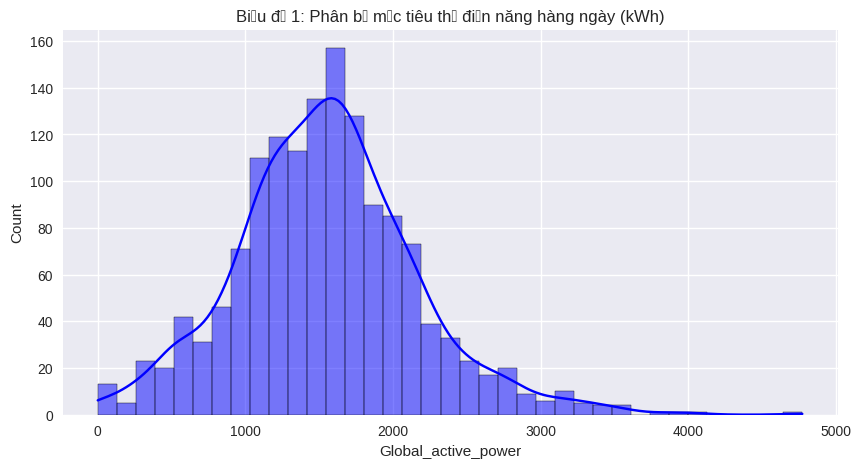

In [19]:
plt.figure(figsize=(10, 5))
sns.histplot(data['Global_active_power'], kde=True, color='blue')
plt.title('Biểu đồ 1: Phân bổ mức tiêu thụ điện năng hàng ngày (kWh)')
plt.show()

2.2. Ma trận tương quan

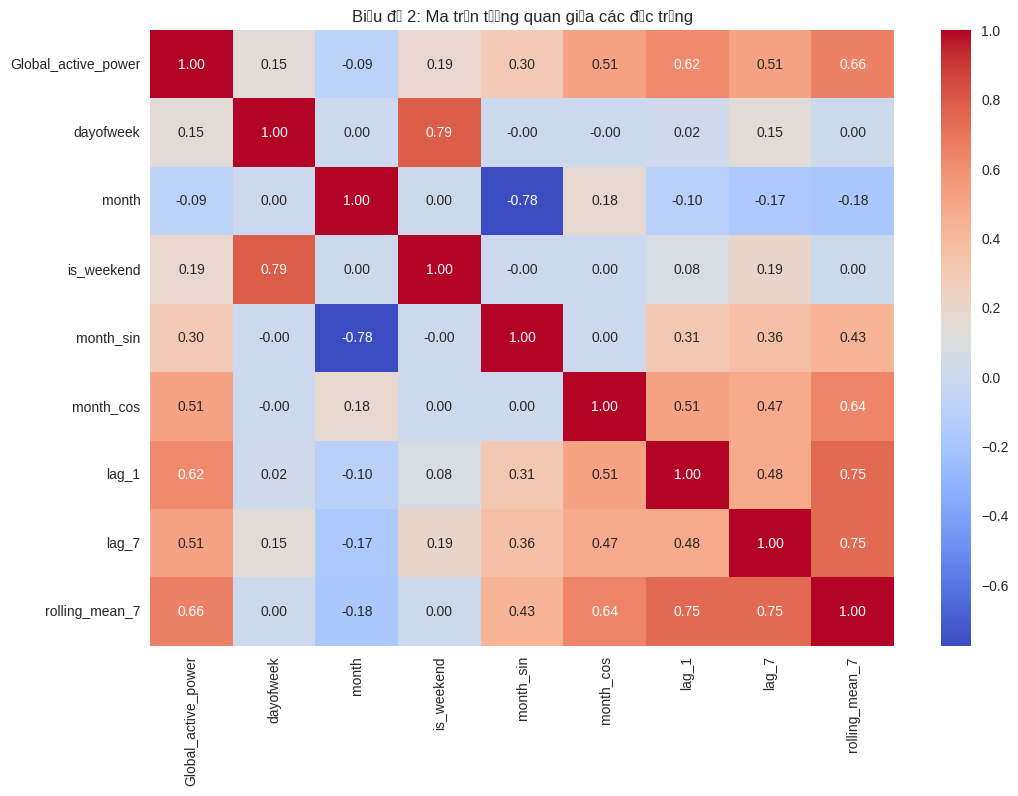

In [20]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Biểu đồ 2: Ma trận tương quan giữa các đặc trưng')
plt.show()

## **3. HUẤN LUYỆN VÀ DỰ BÁO CUỐN CHIẾU (RECURSIVE FORECASTING)**

---
3.1. Chia dữ liệu và Chuẩn hóa

---




In [14]:
data = create_advanced_features(df_daily)
train_size = int(len(data) * 0.8)
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

X_train = train_data.drop('Global_active_power', axis=1)
y_train = train_data['Global_active_power']

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)



---

3.2. Workflow Dự báo cuốn chiếu

---



In [15]:
def recursive_forecast_v2(model, last_30_days_df, steps=30):
    forecasts = []
    temp_df = last_30_days_df.copy()

    for i in range(steps):
        # Bước quan trọng: Tính lại toàn bộ lag/rolling từ temp_df đã có kết quả dự báo trước đó
        full_features = create_advanced_features(temp_df)

        # Lấy dòng cuối cùng (ngày cần dự báo)
        X_current = full_features.drop('Global_active_power', axis=1).iloc[[-1]]
        X_current_scaled = scaler.transform(X_current)

        # Dự báo
        pred = model.predict(X_current_scaled)[0]
        pred = max(0, pred) # Luôn đảm bảo không âm
        forecasts.append(pred)

        # Cập nhật kết quả vào temp_df để vòng lặp sau tính lag_1, lag_7 đúng
        next_date = temp_df.index[-1] + pd.Timedelta(days=1)
        new_row = pd.DataFrame({'Global_active_power': [pred]}, index=[next_date])
        temp_df = pd.concat([temp_df, new_row])

    return forecasts

## **4. THỰC NGHIỆM VÀ SO SÁNH 4 MÔ HÌNH**

---

4.1. Chạy mô hình

---



In [16]:
# Sửa đổi tham số để mô hình "hiền" hơn, tránh Overfitting
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(
        n_estimators=100,
        max_depth=7,        # Giới hạn độ sâu để bớt phức tạp
        random_state=42
    ),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.03, # Giảm tốc độ học
        max_depth=3,        # Cây nông để bền bỉ hơn khi dự báo xa
        random_state=42
    ),
    "XGBoost": xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.03,
        max_depth=3,        # Đây là mức tối ưu để giảm Recursive Drift
        subsample=0.8,      # Chỉ lấy 80% dữ liệu cho mỗi cây để tăng tính tổng quát
        random_state=42
    )
}
# Lấy ít nhất 31 ngày cuối của tập Train (đủ để tính lag_30 nếu có)
# Đảm bảo history_df là dữ liệu gốc (chưa qua scaler) vì v2 sẽ tự xử lý bên trong
history_df = df_daily.iloc[train_size - 35 : train_size]

actual_30d = test_data['Global_active_power'][:30]

results = {}
for name, model in models.items():
    # Bước 1: Huấn luyện trên toàn bộ tập Train đã chuẩn hóa
    model.fit(X_train_scaled, y_train)

    # Bước 2: Dự báo cuốn chiếu sử dụng hàm v2 (Đảm bảo hàm v2 gọi đúng scaler)
    # Lưu ý: Truyền history_df (gốc) vào để hàm tính toán features đúng quy trình
    results[name] = recursive_forecast_v2(model, history_df, steps=30)

    print(f"✓ Hoàn thành dự báo tối ưu: {name}")

✓ Hoàn thành dự báo tối ưu: Linear Regression
✓ Hoàn thành dự báo tối ưu: Random Forest
✓ Hoàn thành dự báo tối ưu: Gradient Boosting
✓ Hoàn thành dự báo tối ưu: XGBoost


## **5. TỔNG HỢP VÀ TRỰC QUAN HÓA KẾT QUẢ**

---

5.1. Biểu đồ so sánh sai số tổng tháng (%)

---



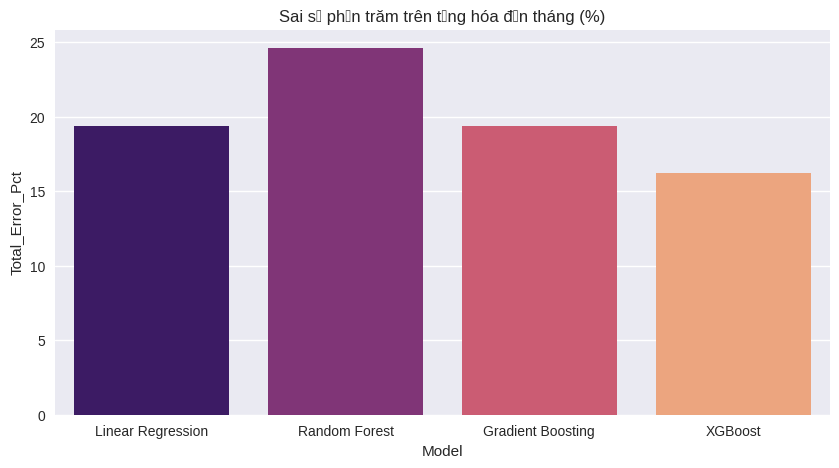

In [17]:
actual_total = actual_30d.sum()
summary = []
for name, preds in results.items():
    err = abs(actual_total - np.sum(preds)) / actual_total * 100
    summary.append({'Model': name, 'Total_Error_Pct': err})

df_summary = pd.DataFrame(summary)
plt.figure(figsize=(10, 5))
sns.barplot(x='Model', y='Total_Error_Pct', data=df_summary, palette='magma')
plt.title('Sai số phần trăm trên tổng hóa đơn tháng (%)')
plt.show()



---
5.2. Trực quan hóa đường dự báo mô hình tốt nhất

---




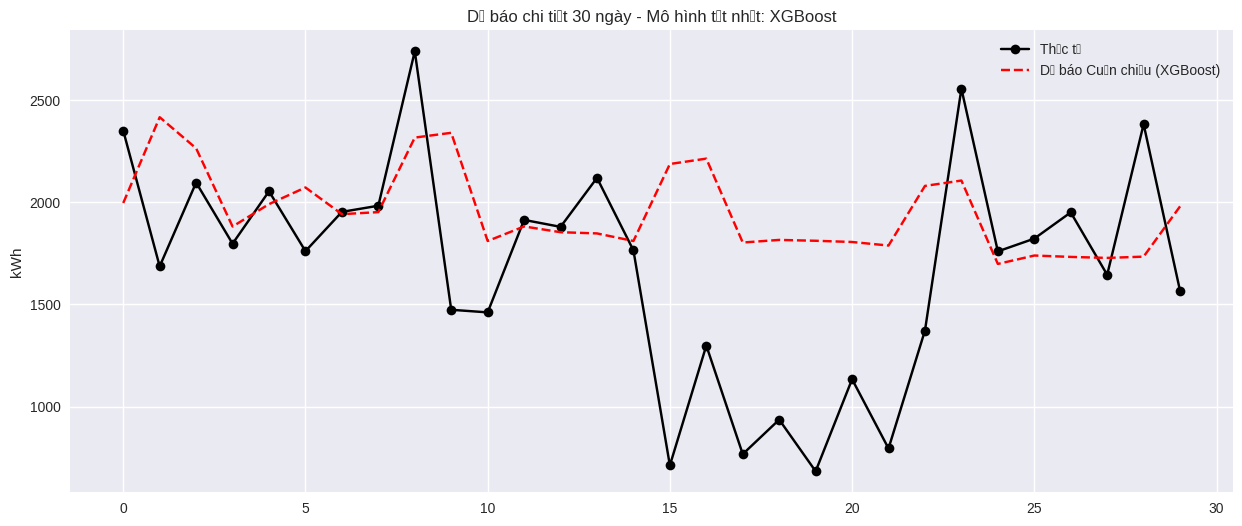

In [18]:
best_m = df_summary.loc[df_summary['Total_Error_Pct'].idxmin(), 'Model']
plt.figure(figsize=(15, 6))
plt.plot(actual_30d.values, label='Thực tế', color='black', marker='o')
plt.plot(results[best_m], label=f'Dự báo Cuốn chiếu ({best_m})', color='red', linestyle='--')
plt.title(f'Dự báo chi tiết 30 ngày - Mô hình tốt nhất: {best_m}')
plt.ylabel('kWh')
plt.legend()
plt.show()